In [2]:
import os, pathlib
os.chdir(pathlib.Path(globals()['_dh'][0]).parent)

In [3]:
from pendsim import sim, controller, viz
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# PID Notebook

PID, or proportional-integral-derivative, control is a model-free feedback policy which uses an error signal and tunable gains to compute a control action that produces a desired system response.

![PID.png](PID.png)

The block diagram of the PID system in the time domain is shown above. Given the error signal $e(t)$, we tune the three gains, $K_p, K_i$ and $K_d$, to generate the control signal, $u(t)$. The control signal reaches the physical system (the *plant / process*), which finally produces some output $y(t)$. (Graphic is sourced from Wikipedia).

For more information about PID control, see [Feedback Systems:
An Introduction for Scientists and Engineers, Ch 10](https://people.duke.edu/~hpgavin/SystemID/References/Astrom-Feedback-2006.pdf), or for a less technical introduction, [Wikipedia](https://en.wikipedia.org/wiki/PID_controller).

---
To start, we create our system. Here, we have a cart/pendulum with a 2kg cart, 1kg mass, and 2-meter length. We create a PID controller that can resist the force given by the impulsive `force_func`, which peaks at $t=2$s and with magnitude 20N. The simulation lasts from $t=0$ to $t_{\text{final}}=10$s.

The feedback control policy is simple, but how can we set the gains for our controller? Fortunately, we are not too worried about the pendulum falling over, so we can experiment a bit, and hopefully gain some intuition about PID control.

In [4]:
pend = sim.Pendulum(
    2.0, # Pendulum base mass
    1.0, # Pendulum ball mass
    2.0, # Pendulum length
    initial_state = np.array([0.0, 0.0, 0.0, 0.0])
)

dt, t_final = 0.01, 10
def force_func(t):
    return 20 * np.exp( -(  ((t-2.0)/0.1)**2) )
simu10 = sim.Simulation(dt, t_final, force_func)

A PID controller has three gains, that we call `kp`, `ki`, `kd` here. These are also called the proportional, integral, and derivative gains.

To start, we set all to zero. This zero-gain controller fails to stabilize the pendulum system against the external force that's applied, becasue all of the coefficients in front of the actuation are 0! So, with all gains 0, the controller takes no action at all. We can see that as soon as the external force starts being applied, $\theta$ sees a sudden increase and the pendulum is knocked over.

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1122.54it/s]


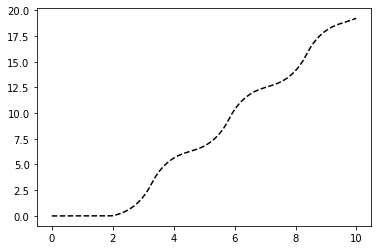

In [5]:
kp, ki, kd = 0.0, 0.0, 0.0
cont = controller.PID((kp, ki, kd))
results = simu10.simulate(pend, cont)
fig1, ax1 = plt.subplots()
ax1.plot(results[('state','t')], 'k--', label='theta')

plt.show()

And for a visual confirmation of our suspicion, we visualize the virtual experiment:

In [ ]:
visu = viz.Visualizer(results, pend, dt)
ani = visu.animate()
HTML(ani.to_html5_video())

To tune, we begin with the proportional gain, called `kp`. Let's start it at zero and slowly increase it, and see what happens. Let's create several controllers, increasing the gain by $k_p = k_p + 2.5$ for each controller. Our ultimate goal is to stabilize the pendulum system in the upright position. So that means we want $\theta$ to settle at 0.

For this simple PID policy, we are going to limit ourselves to stabilizing $\theta$. So for our purposes, the input is the angle $\theta$ and the output is the control actuation, $u$.

In [ ]:
# starting gain
kp = 0.0
# no of times to increase the gain
n = 32
# amount to increase by
increase_by = 2.5
# empty lists
conts = []
pends = [pend] * n
gains = []
for _ in range(n):
    # increase the gain
    kp += increase_by
    # set ki, kd to 0
    pid = kp, 0.0, 0.0
    conts.append(controller.PID(pid))
    gains.append(kp)
# simulate each controller
all_results = simu10.simulate_multiple(pends, conts)

Now, let's see how $\theta$ is performing for each gain.

In [ ]:
nrows, ncols = 8, 4
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15,20))
axn, ax_idxs = 0, {}
# index helper map for plots
for i in range(nrows):
    for j in range(ncols):
        ax_idxs[axn] = (i, j)
        axn += 1
# create figures and set the title as the gain
for g, (idx, res), (axi, axj) in zip(gains, all_results.groupby(level=0), ax_idxs.values()):
    res.index = res.index.droplevel(0)
    ax1[axi, axj].plot(res[('state', 't')])
    ax1[axi, axj].set_title('gain=' + str(g))
# label figures
for i in range(nrows):
    ax1[i, 0].set_ylabel('theta (rad)')
for j in range(ncols):
    ax1[-1, j].set_xlabel('time (s)')
plt.show()

So, here we can see that right around $k_p=50.0$, we get a stabilization of the pendulum, instead of theta getting away faster than the controller can stabilize it. Let's tune a bit more aggressively than the marginal case and set our gain: $k_p=80.0$.

These results should make intuitive sense with a bit of control systems knowledge: adding a proportional gain, in general, makes the system response faster. We also can see some instability in the system as well: as we increase the gain, so too the oscillations increase.

The pendulum is (somewhat) stable around $\theta=0$, but we still have a pesky oscillation. Can we remove it?

There is one more thing going on here. It appears that the system is oscillating, but also that the oscillations are increasing in magnitude. Eventually, this instability will compound enough to topple the pendulum, despite having a proportional controller in place with a suitable gain. To see this, we can increase the simulation time, this time to 40 seconds instead of 10.

In [ ]:
kp = 80.0
cont = controller.PID( (kp, 0, 0) )
simu30 = sim.Simulation(dt, 40, force_func)
res_proportional = simu30.simulate(pend, cont)

And we plot our longer-term simulation:

In [ ]:
_, ax = plt.subplots()
ax.plot(res_proportional[('state', 't')])
ax.set_ylabel("Angle (rads)")
ax.set_xlabel("Time (s)")
plt.show()

We do see that at around the 30 second mark, the oscillation knocks over the pendulum. 

We also see what looks like a response associated with a positive real pole: a steady oscillation bounded by an envelope of an increasing exponential -- that is, until the whole thing gets knocked over. Physically, what is going on here? The problem arises with the presence of the external force. 

The external force impacts the higher-order terms of the system. If we solve the initial value problem (i.e., simulate!) just *after* the force is applied, there is a little bit of a velocity term in the initial value. If this velocity term is 0, the P-only controller will oscillate forever -- it is *marginally* stable. But if we add even a tiny bit of velocity in the I.V.P, the system is unstable with P-only control.

This manifests as an oscillation: the controller pushes a little bit too hard right, and the pendulum overshoots a bit to the left; then, the controller pushes left, and the pendulum overshoots a bit (more!) to the right, and the process continues until the pendulum tips over.

The integral term, $k_i$, is not needed here; since the oscillations are centered at the zero point, there would be, if the oscillations were driven to zero, no steady state error. On the other hand, a derivative term seeks to drive the rate of change of the error closer to zero over time. Practically, this means that it can counteract the magnitude of steady oscillation we see, and as a result, bring the system to stability. 

Below, we follow the same experimental process for tuning: slowly increase $k_d$ and see the effects. In real-life systems, where failure can have expensive or dangerous consequences, tuning is a very delicate process, typically informed heavily by process knowledge. Here, we have no such limits. 

In [ ]:
kp = 80.0
kd = 0.0
n = 16
increase_by = 1.25
conts = []
pends = [pend] * n
gains = []
for _ in range(n):
    # increase the gain
    kd += increase_by
    # set ki, kd to 0
    pid = kp, 0.0, kd
    conts.append(controller.PID(pid))
    gains.append(kd)
# simulate each controller
all_results = simu10.simulate_multiple(pends, conts)

nrows, ncols = 4, 4
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15,12))
axn, ax_idxs = 0, {}
for i in range(nrows):
    for j in range(ncols):
        ax_idxs[axn] = (i, j)
        axn += 1
for g, (idx, res), (axi, axj) in zip(gains, all_results.groupby(level=0), ax_idxs.values()):
    res.index = res.index.droplevel(0)
    ax1[axi, axj].plot(res[('state', 't')])
    ax1[axi, axj].set_title('gain=' + str(g))
# label plots
for i in range(nrows):
    ax1[i, 0].set_ylabel('theta (rad)')
for j in range(ncols):
    ax1[-1, j].set_xlabel('time (s)')

plt.show()

Now, we look again at $\theta$. It looks significantly better! The addition of a derivative component drives the oscillations towards zero. To see the effect, we can plot the two controllers next to one another, one with the $k_d$ and one without. 

In [ ]:
res_p_10 = simu10.simulate(pend, controller.PID((80, 0.0, 0.0)))
res_pd_10 = simu10.simulate(pend, controller.PID((80, 0.0, 10)))

fig, ax = plt.subplots()
ax.plot(res_pd_10[('state', 't')], 'b-', label='With derivative')
ax.plot(res_p_10[('state', 't')], 'r--', label='Without Derivative')
ax.set_ylabel('Angle (rads)')
ax.set_xlabel('Time (s)')
ax.legend()
plt.show()

The difference is stark!

Finally, we can look at a visualization of how this controller performed. 

In [ ]:
visu = viz.Visualizer(res_pd_10, pend, dt)
ani = visu.animate(blit=True)
HTML(ani.to_html5_video())

Since this simulation is relatively accurate, we expect that a pendulum with the same attributes (length, mass, etc.), if controlled by a controller with the same gain (as expressed in N of force applied), would have similar stability characteristics -- so long as we could accurately measure the state!

Tuning a controller in simulation is a common way to implement a controller in a physical system when the consequences of bad tuning can be disasterous. If there were serious consequences to knocking over our pendulum, we would want to use the gains we have discovered here as a starting point.